# IST Connectomics lab 2026 (Python / Colab)

## Topics
### Chapter 1
- Connectivity matrices: visual inspection, thresholding, netowork density, nodal degree
- Consensus matrix and group-representative graphs
- Streamline lengh bias
### Chapter 2
- Integration and segregation: shortest path length, efficiency, clustering coefficient
- Randomized networks (null model)
- Small-world index
### Chapter 3
- Group comparison of global and nodal topological measures (CTRL vs SCHZ)
- Nodal closeness centrality
- Multiple comparison correction

## Python libraries and resources
This lab uses [**bctpy**](https://github.com/aestrivex/bctpy), Brain Connectivity Toolbox (BCT) for Python version 0.6.1.
*bctpy* requires *numpy* and *scipy*.

[**BCT**](https://sites.google.com/site/bctnet/) is a collection of *MATLAB* functions that compute graph theoretical measures and implement associated algorithms, such as shortest-path identification and community detection, specifically developed for *brain networks' analysis*. The majority of graph measures implemented in BCT are described in [Rubinov & Sporns, 2010](https://www.sciencedirect.com/science/article/abs/pii/S105381190901074X?via%3Dihub).

**bctpy** should be considered beta software, with **BCT** being the gold standard by comparison.

Of note, [**NetworkX**](https://networkx.org/documentation/stable/index.html) (not used in this lab) is a *Python* package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. 

## Inputs (Python-native)
- `Brainlab_Connectomics_Data.npz` containing `SC_ctrl`, `SC_schz` (shape: `nn × nn × ns`)
- `Brainlab_Connectomics_Labels.json` list of region labels (length: `nn`)
- `Euclidean_Distance.npz` containing `Edist` (shape: `nn × nn`) Euclidean distances between centroids

## 0.1 Setup

In [1]:
import sys

# If running in Colab, install required libraries.
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip -q install bctpy statsmodels seaborn

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu, spearmanr
import seaborn as sns
import bct
from statsmodels.stats.multitest import multipletests

# Reseed the singleton RandomState instance for reproducibility
np.random.seed(42)
plt.rcParams.update({"font.size": 14})

print("Colab:", IN_COLAB)
print("Python:", sys.version.split()[0])

Colab: False
Python: 3.11.14


## 0.2 Download data

In [4]:
# --- Data setup: works in Colab and locally ---
import os
import urllib.request
from pathlib import Path

# Folder where this notebook expects data to be
DATA_DIR = Path("Data")


BASE_URL = "https://raw.githubusercontent.com/agriffa/IST_Connectomics_Lab/main/Data/"

FILES = [
    "Brainlab_Connectomics_Data.npz",
    "Brainlab_Connectomics_Labels.json",
    "Euclidean_Distance.npz"
]

def download_if_missing(fname: str):
    out_path = DATA_DIR / fname
    if out_path.exists():
        return

    if not IN_COLAB:
        # Local run: do not auto-download silently
        raise FileNotFoundError(
            f"Missing {out_path}. If you are running locally, "
            f"please download the file from the course repository and place it in {DATA_DIR}/."
        )

    # Colab run: auto-download from GitHub
    url = BASE_URL + fname
    print(f"Downloading {fname} ...")
    urllib.request.urlretrieve(url, out_path)

# Create Data folder only in Colab
if IN_COLAB:
    DATA_DIR.mkdir(exist_ok=True)
    
for fname in FILES:
    download_if_missing(fname)

print("Data ready in:", DATA_DIR.resolve())
print("Files in Data directory:", [p.name for p in DATA_DIR.iterdir() if p.is_file()])


Data ready in: /Users/agriffa/Documents/GITHUB/IST_Connectomics_Lab/Data
Files: ['.DS_Store', 'Original_Connectomics_Data.npz', 'Brainlab_Connectomics_Data.npz', 'Euclidean_Distance.npz', 'Brainlab_Connectomics_Labels.json']


## 0.3 Load data

In [5]:
DATA_NPZ = DATA_DIR / "Brainlab_Connectomics_Data.npz"
LABELS_JSON = DATA_DIR / "Brainlab_Connectomics_Labels.json"
EDIST_NPZ = DATA_DIR / "Euclidean_Distance.npz"

data = np.load(DATA_NPZ)
SC_ctrl = data["SC_ctrl"]
SC_schz = data["SC_schz"]
data = np.load(EDIST_NPZ)
Edist = data["Edist"]

with open(LABELS_JSON, "r", encoding="utf-8") as f:
    labels = json.load(f)

assert len(labels) == SC_ctrl.shape[0], "labels length does not match nn"


---
# CHAPTER 1 — Gain confidence with brain connectivity matrices
---

The brain is a complex system composed of neuronal groups connected through axonal projections and interacting at multiple temporal scales. Long-range axonal projections can be investigated *in vivo* with diffusion-weighted Magnetic Resonance Imaging (DWI). Functional MRI (fMRI), electroencephalography (EEG), and related techniques record signals representative of local neural activity. Brain regions with correlated functional activities are said to be functionally connected, and whole-brain functional connectivity maps can be derived.
Both structural and functional brain connectivity information can be represented in the form of a network, where nodes represent grey matter regions and edges white matter tracts (structural connectivity) or statistical relationships between recorded signals (functional connectivity). A network (or graph) is a mathematical object described by its connectivity (or adjacency) matrix. The connectivity matrix is used to compute different quantitative measures describing topological features of the network, such as its efficiency or its modular structures.

In this hands-on session, you will investigate topological features of human brain structural networks (or structural connectomes) estimated from Diffusion Spectrum Imaging (DSI) data and deterministic streamline tractography. Each network represents the macroscale white matter connectivity between 68 cortical regions (34 regions per hemisphere) and 14 subcortical regions (7 per hemisphere) as defined by the Desikan-Killiany brain atlas ([Desikan et al., 2006](https://www.sciencedirect.com/science/article/abs/pii/S1053811906000437)). We provide networks of healthy subjects (controls, referred to as ctrl here onwards) as well as patients affected by schizophrenia (schz).

## 1.1 Inspect variables

In [6]:
print("LIST OF LOADED VARIABLES")
print(" ")
print("SC_ctrl:", type(SC_ctrl), SC_ctrl.shape)
print("SC_schz:", type(SC_schz), SC_schz.shape)
print("Edist:", type(SC_ctrl), Edist.shape)
print("labels:", type(labels), len(labels))

nn, _, ns = SC_ctrl.shape

LIST OF LOADED VARIABLES
 
SC_ctrl: <class 'numpy.ndarray'> (82, 82, 15)
SC_schz: <class 'numpy.ndarray'> (82, 82, 15)
Edist: <class 'numpy.ndarray'> (82, 82)
labels: <class 'list'> 82


<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br>
    Inspect the loaded variables.
    What do these variables represent ?<br>
    What is the <b>order</b> (number of nodes) of the brain networks ?<br>
</div>

## 1.2 Visualize a single-subject connectivity matrix

Let's now extract a single-subject connectivity matrix and store it in a new variable *A*.  
Note the usage of the symbol `:` to select all the elements of the array *SC_ctrl* along the first and second dimensions.<br>
Here, we select the first control subject (Python indexing starts at *0*).

In [7]:
# Single subject
A = SC_ctrl[:, :, 0]
print("A:", type(A), A.shape)

# log scale
A_log = np.zeros_like(A, dtype=float)
m = A > 0
A_log[m] = np.log(A[m]) # avoid log(0)

A: <class 'numpy.ndarray'> (82, 82)


Use the *matplotlib* library to visualize the connectivity matrix and the histogram of the (non-zero) connectivity weights.  
To ease visualization, display the matrix using a logarithmic scale.

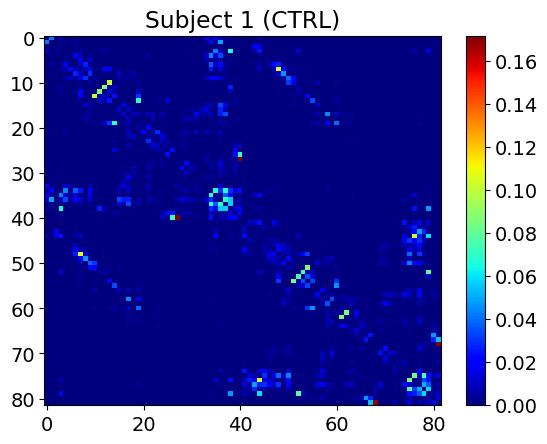

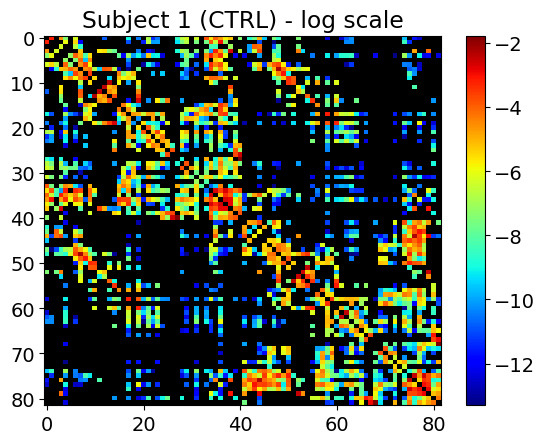

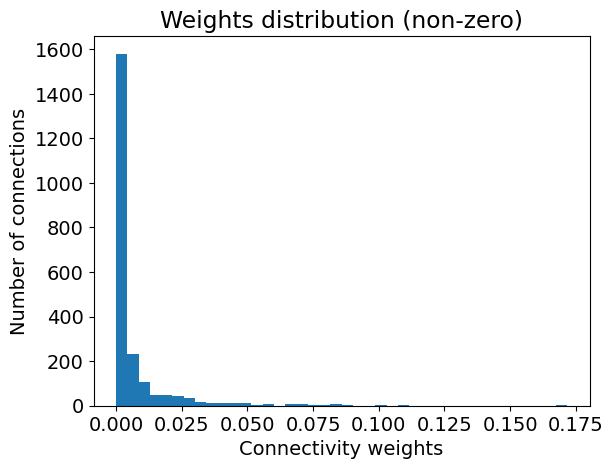

In [8]:
# Figure
plt.figure()
plt.imshow(A, cmap=plt.cm.jet)
plt.axis("equal"); plt.axis("tight")
plt.colorbar()
plt.title("Subject 1 (CTRL)")
plt.show()

# Figure
cmap = plt.cm.jet.copy()   # copy the colormap
cmap.set_bad(color="black")  # color for masked values
A_log_masked = np.ma.masked_where(A_log == 0, A_log)
plt.figure()
plt.imshow(A_log_masked, cmap=cmap)
plt.axis("equal"); plt.axis("tight")
plt.colorbar()
plt.title("Subject 1 (CTRL) - log scale")
plt.show()

# Figure
plt.figure()
plt.hist(A[A > 0].ravel(), bins=40) # .ravel() flattens the array into a 1D vector
plt.xlabel("Connectivity weights")
plt.ylabel("Number of connections")
plt.title("Weights distribution (non-zero)")
plt.show()

<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    Is the network <b>directed or undirected</b>? Why?<br>  
    Are there <b>self-loops</b>?<br><br>
    Can you identify any <b>visual patterns</b> in the matrix such as quadrants and diagonals?<br>  
    Aid yourself from the content of variable labels.<br><br>
    Can you hypothesize which choice was made to define the <b>connectivity weights</b>?<br> 
    Where do you find the connections with the highest and lowest connection weights?<br> 
    Would you expect a similar pattern when choosing different types of connection weights (e.g., fractional anisotropy)?<br>
</div>

NOTE that you can verify whether the network is directed or undirectd by simpe manipulations of the adjacency matrix: 

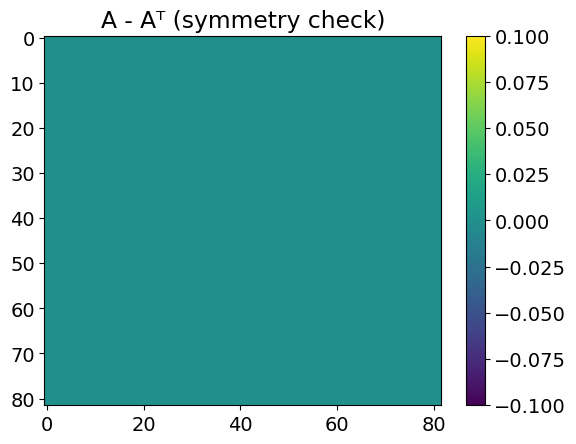

Is symmetric (allclose): True
Self-loops indices (diag != 0): []


In [9]:
plt.figure()
plt.imshow(A - A.T)
plt.axis("equal"); plt.axis("tight")
plt.colorbar()
plt.title("A - Aᵀ (symmetry check)")
plt.show()

# allclose returns True if two arrays are element-wise equal within a tolerance
print("Is symmetric (allclose):", np.allclose(A, A.T))

self_loops = np.where(np.diag(A) != 0)[0]
print("Self-loops indices (diag != 0):", self_loops)

## 1.3 Thresholding (binary)

So far, we have been working with a weighted network, but sometimes it can be interesting to work with a binary equivalent. Let’s then convert `A` into an unweighted network. Note that in Python the result of the operation `(A > th)` is a boolean matrix, which can then be converted into a numerical matrix.

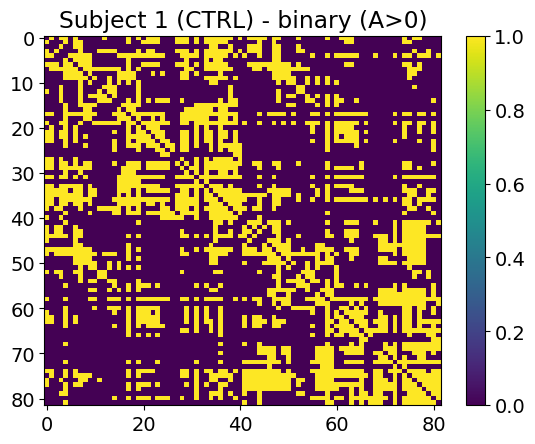

In [10]:
th = 0  
B = (A > th).astype(float)

plt.figure()
plt.imshow(B)
plt.axis("equal"); plt.axis("tight")
plt.colorbar()
plt.title("Subject 1 (CTRL) - binary (A>0)")
plt.show()

<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    What is the meaning of the variable <i>th</i>? Could we choose a different threshold value?<br>
    Is there any relationship between the threshold value and the number of <b>false positive and false negative connections</b> one might expect in the network <i>B</i>?<br><br>
    What is the <b>density</b> of the network? (execute the following cell)<br>  
    How did you take into account the fact that the network is undirected?<br><br>
    Are there <b>disconnected nodes</b> in the network? (hint: compute and visualize the degree sequence)<br>  
</div>

In [13]:
print("Number of nodes = ", nn)

# --- compute density of single subject network B ---
d_single_subject = np.sum(B) / (nn * (nn-1))
print("Density (single subject): ", d_single_subject)

# --- compute degree sequence ---
k_single_subject = np.sum(B, axis=0) 

# --- verify whether there are diconnected nodes ---
print("Number of disconnected nodes: ", np.sum(k_single_subject == 0))


Number of nodes =  82
Density (single subject):  0.331225534477567
Number of disconnected nodes:  0


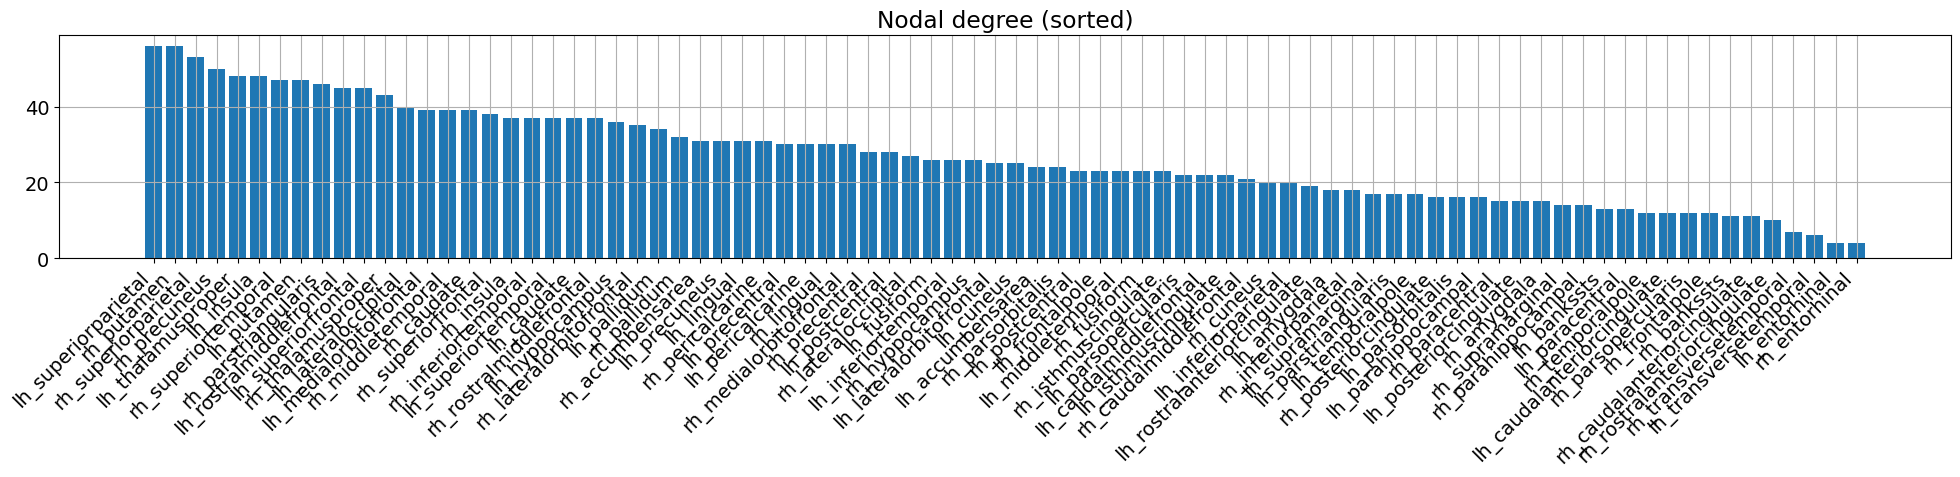

In [14]:
# Plot sorted degree sequence
ix_sort = np.argsort(-k_single_subject)
plt.figure(figsize=(20, 5))
plt.bar(np.arange(nn), k_single_subject[ix_sort])
plt.grid(True)
plt.title("Nodal degree (sorted)")
plt.xticks(np.arange(nn), [labels[i] for i in ix_sort], rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 1.4 Consensus matrix and length bias

In many situations, it can be useful to obtain a network representative of a whole group of subjects.  
A possible way to build such a **group-representative network** is to select the connections that are present in at least a certain percentage of subjects from the group.  
To do so, let’s first threshold each individual connectivity matrix from control subjects:

In [17]:
print("Number of ctrl subjects = ", ns)

SC_ctrl_bin = (SC_ctrl > th).astype(float)

C_ctrl = SC_ctrl_bin.sum(axis=2) / ns  # consensus proportion

Number of ctrl subjects =  15


<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    Check the size of the variables <i>SC_ctrl_bin</i> and <i>C_ctrl</i>.<br>
    Visualize the latter and plot its histogram.<br><br>
    What is the meaning of matrix <i>C_Ctrl</i>?<br>
    What is the proportion of region pairs that are consistently connected (or disconnected) over the 15 healthy subjects?<br> 
    How do these numbers compare to the distribution of the individual networks’ densities?<br>  
</div>

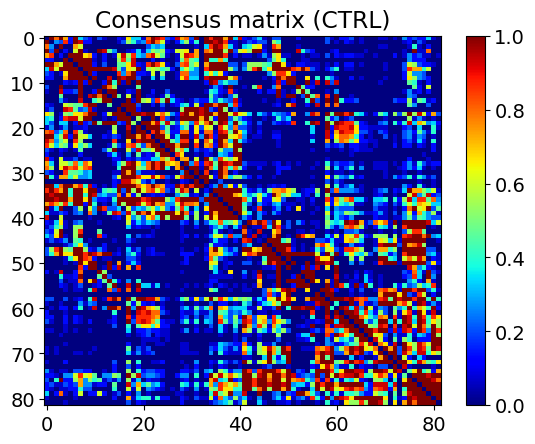

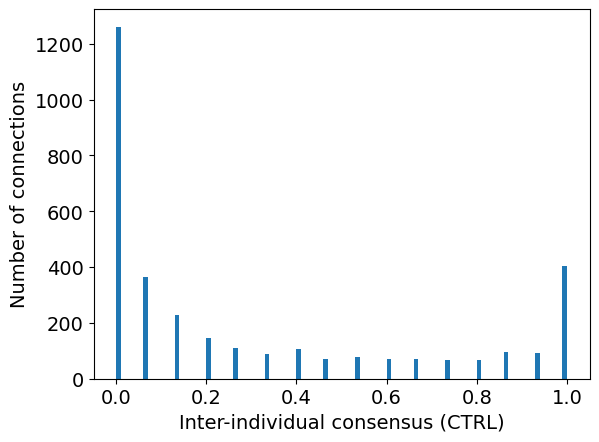

In [18]:
# Figure
plt.figure()
plt.imshow(C_ctrl, cmap=plt.cm.jet)
plt.axis("equal"); plt.axis("tight")
plt.colorbar()
plt.title("Consensus matrix (CTRL)")
plt.show()

# Histogram of upper triangle (excluding diagonal)
ut = np.triu(np.ones((nn, nn), dtype=bool), 1)
plt.figure()
plt.hist(C_ctrl[ut].ravel(), bins=100) # ravel returns a contiguous flattened array
plt.xlabel("Inter-individual consensus (CTRL)")
plt.ylabel("Number of connections")
plt.show()

Proportion of regions pairs consistently connected in all subjects (over pairs connected in at least one subject):0.20
Proportion of regions pairs disconnected in all subjects:0.39


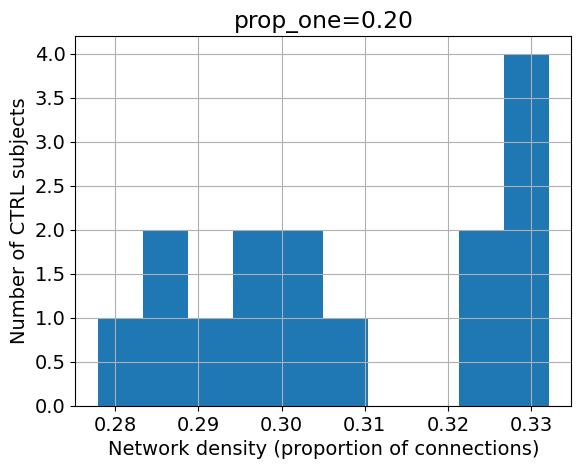

In [27]:
# --- compute the proportion of regions pairs consistently connected (disconnected) ---
prop_one = np.sum(C_ctrl == 1) / np.sum(C_ctrl > 0)
prop_zero = np.sum(C_ctrl == 0) / (nn * (nn-1))

print(f"Proportion of regions pairs consistently connected in all subjects (over pairs connected in at least one subject):{prop_one:.2f}")
print(f"Proportion of regions pairs disconnected in all subjects:{prop_zero:.2f}")

# --- how prop_one compare to the distribution of the individual networks’ densities ---
d_ctrl = np.sum(SC_ctrl > 0, axis=(0, 1)) / (nn * (nn - 1))  # shape (ns,)

# Histogram
plt.figure()
plt.hist(d_ctrl, bins=10)
plt.grid(True)
plt.xlabel("Network density (proportion of connections)")
plt.ylabel("Number of CTRL subjects")
plt.title(f"prop_one={prop_one:.2f}")
plt.show()

Now build and visualize a group-representative connectivity matirx for the ctrl group applying a **uniform consistency threshold**:

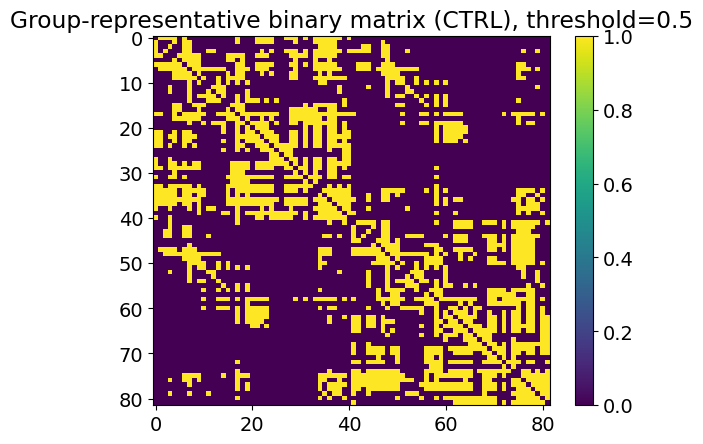

Group density: 0.2830472749171936


In [28]:
th_perc = 0.5
SC_ctrl_group = (C_ctrl >= th_perc).astype(float)

plt.figure()
plt.imshow(SC_ctrl_group)
plt.axis("equal"); plt.axis("tight")
plt.colorbar()
plt.title(f"Group-representative binary matrix (CTRL), threshold={th_perc}")
plt.show()

print("Group density:", np.count_nonzero(SC_ctrl_group) / (nn * (nn - 1)))

<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    What does the variable <i>th_perc</i> represent?<br><br>
    Can you observe any visual pattern in matrix <i>C_ctrl</i>?<br>
    Do you think these patterns may yield any bias in the group-representative matrix <i>SC_ctrl_group</i>?<br>  
</div>

To further explore this last issue, consider the variable *Edist*, which contains the Euclidean distance between the centroids of region pairs in MNI space. Explore the relationship between **inter-individual consensus values** and **spatial distance** between region pairs.

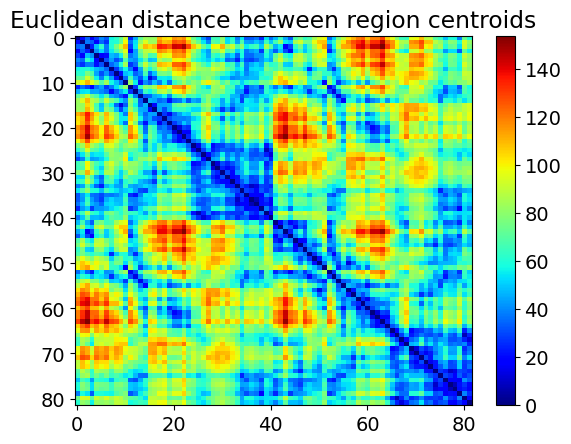

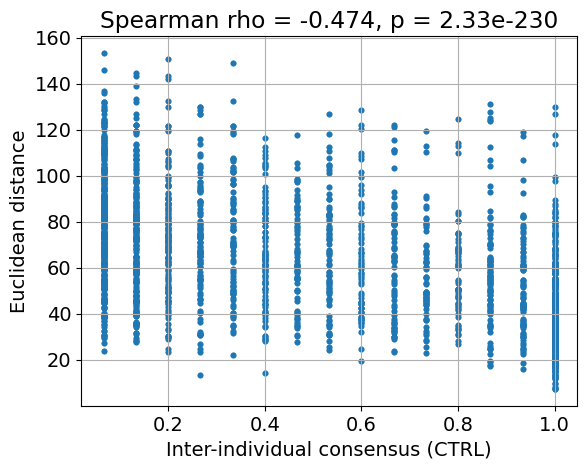

In [30]:
# Visualize Edist
plt.figure()
plt.imshow(Edist, cmap=plt.cm.jet)
plt.axis("equal"); plt.axis("tight")
plt.colorbar()
plt.title("Euclidean distance between region centroids")
plt.show()

# Rank correlation between Edist and C_ctrl
rho, p = spearmanr(C_ctrl[C_ctrl>0], Edist[C_ctrl>0])

# Scatter plot
plt.figure()
plt.scatter(C_ctrl[C_ctrl>0], Edist[C_ctrl>0], s=10)
plt.grid(True)
plt.xlabel("Inter-individual consensus (CTRL)")
plt.ylabel("Euclidean distance")
plt.title(f"Spearman rho = {rho:.3f}, p = {p:.3g}")
plt.show()


<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    Describe what you observe. Are consensus values and Euclidean distances significantly correlated?<<br><br>
    Can you think of possible thresholding strategies to attenuate the <b>length bias</b> in group-representative matrices??<br>
</div>

---
# CHAPTER 2 — Integration, segregation, small-world
---

In this chapter, you will compute network measures to characterize **integration** and **segregation** properties of the brain network.
 
Broadly speaking, integration measures quantify how easy it is to go from one node of the network to another distant one, or the efficiency of communication across the entire network. Brain integration properties are thought to underlie higher-order brain functions, such as cognitive processing, and have been shown to be affected in different neuropsychiatric disorders.

Segregation measures describe the degree to which a network is organized into densely connected subgroups, at multiple scales of investigation. The presence of densely connected subgroups of brain regions can mirror functional specialization properties. 

A network that combines good integration and segregation properties is called **small-world**.

## 2.1 Distance matrix, characteristic path length and clustering coefficient

Let’s consider the group-representative network that we have just created.
We will use the Brain Connectivity Toolbox *bctpy* to compute the distance matrix associated with `SC_ctrl_group`.


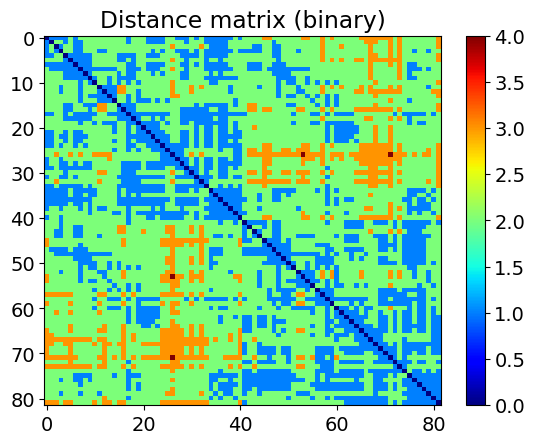

In [31]:
D_ctrl_group = bct.distance_bin(SC_ctrl_group)

plt.figure()
plt.imshow(D_ctrl_group, cmap=plt.cm.jet)
plt.axis("equal"); plt.axis("tight")
plt.colorbar()
plt.title("Distance matrix (binary)")
plt.show()

<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    What does each entry of matrix <i>D_ctrl_group</i> represent? Why is the matrix "completely filled"?<br><br>
    What are the <b>minimum and maximum distances</b> between two nodes in the brain network SC_ctrl_group?<br>
    What is the unit of measurement of the distance values? Would that be the same for a weighted network?.<br>
    Note the the maximum distance is also called <b>network diameter</b>.<br><br>
    From the distance matrix, compute the <b>characteristic path length</b> (<i>Cpl_ctrl_group</i>) of the network.<br>
    You can verify the correctness of your computation by comparing your output with that of the BCT function charpath<br>
    (see <i>charpath</i> documentation for usage: <i>help(bct.charpath)</i>).<br>
</div>

In [32]:
# --- compute Cpl_ctrl_group from D_ctrl_group and compare your results with the BCTPY charpath function ---
ii = np.triu(np.ones((nn, nn), dtype=bool), 1)
Cpl_ctrl_group = float(np.mean(D_ctrl_group[ii]))
print("Characteristic path length (mean upper triangle):", Cpl_ctrl_group)

Cpl_ctrl_group_bct = bct.charpath(D_ctrl_group)
Cpl_ctrl_group_bct = Cpl_ctrl_group_bct[0]
print("Characteristic path length (BCT):", Cpl_ctrl_group_bct)

Characteristic path length (mean upper triangle): 1.819632640770852
Characteristic path length (BCT): 1.819632640770852


In [35]:
help(bct.charpath)

Help on function charpath in module bct.algorithms.distance:

charpath(D, include_diagonal=False, include_infinite=True)
    The characteristic path length is the average shortest path length in
    the network. The global efficiency is the average inverse shortest path
    length in the network.
    
    Parameters
    ----------
    D : NxN np.ndarray
        distance matrix
    include_diagonal : bool
        If True, include the weights on the diagonal. Default value is False.
    include_infinite : bool
        If True, include infinite distances in calculation. Default value 
        is True.
    
    Returns
    -------
    lambda : float
        characteristic path length
    efficiency : float
        global efficiency
    ecc : Nx1 np.ndarray
        eccentricity at each vertex
    radius : float
        radius of graph
    diameter : float
        diameter of graph
    
    Notes
    -----
    The input distance matrix may be obtained with any of the distance
    functions, 

Next, let’s quantify the **average clustering coefficient** of the brain network using the BCT.<br>
Note that since the clustering coefficient is a nodal measure, we use *np.mean* to compute its average across all nodes of the network.

In [33]:
# --- compute the nodal clustaring coefficient ---
Cl_ctrl_group = bct.clustering_coef_bu(SC_ctrl_group)
avgCl_ctrl_group = float(np.mean(Cl_ctrl_group))

print("Mean clustering (binary group-representative network):", avgCl_ctrl_group)


Mean clustering (binary group-representative network): 0.6314758248843264


<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    What does the clustering coefficient represent?<br>
    Compute yourself the clustering coefficient of a brain region (e.g., node 74) and double-check your result with the output of the <i>bctpy</i> function <i>clustering_coef_bu.</i><br><br>
    Based on the <i>Cpl_ctrl_group</i> and <i>avgCl_ctrl_group</i> values you have computed, can you say whether the network <i>SC_ctrl_group</i> demonstrates short characteristic path length? Does it demonstrate high clustering properties? Can you interpret these topological measures in absolute terms?<br>
</div>

## 2.2 Randomized network (degree-preserving)

It is difficult to assess whether a network has high or low integration properties without comparing it to a reference model. In their seminal paper, Watts and Strogatz compared a series of random networks to a reference model where all connections have the same probability to be drawn (Watts and Strogatz, 1998). Here, we need to think of a good reference model to probe the brain network’s integration and segregation properties.

<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    By definition, a <b>reference or null model</b> preserves some properties of the object under investigation, but it destroys some other properties.<br>
    Which properties of the brain network would you preserve in a fair reference model?<br>
</div>

Use the *bctpy* to compute a reference network from the *SC_ctrl_group network* and visualize it.

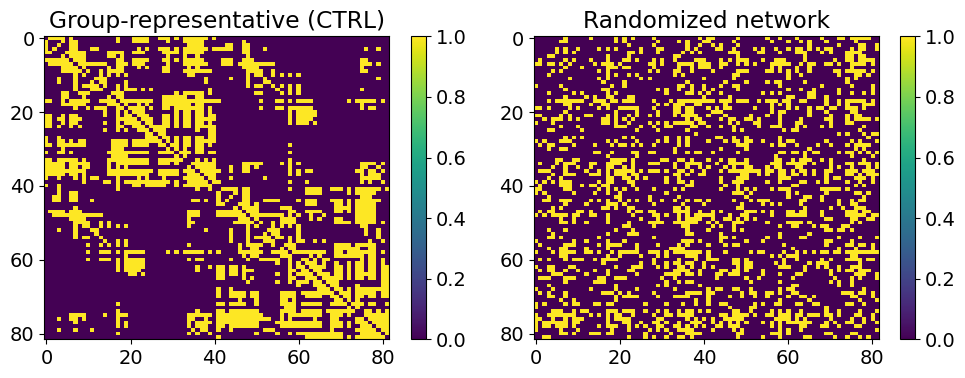

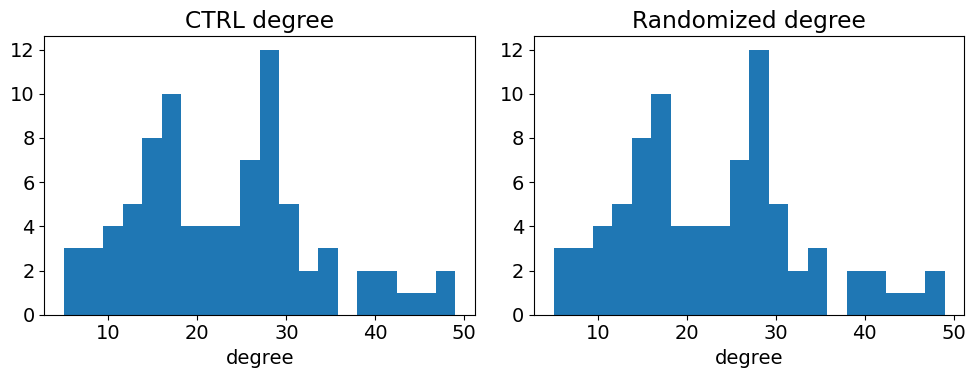

In [35]:
R_ctrl_group, _ = bct.randmio_und(SC_ctrl_group, 100)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(SC_ctrl_group); plt.axis("equal"); plt.axis("tight")
plt.colorbar(); plt.title("Group-representative (CTRL)")

plt.subplot(1,2,2)
plt.imshow(R_ctrl_group); plt.axis("equal"); plt.axis("tight")
plt.colorbar(); plt.title("Randomized network")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(SC_ctrl_group.sum(axis=0), bins=20)
plt.title("CTRL degree"); plt.xlabel("degree")

plt.subplot(1,2,2)
plt.hist(R_ctrl_group.sum(axis=0), bins=20)
plt.title("Randomized degree"); plt.xlabel("degree")
plt.tight_layout()
plt.show()

<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    Visually compare the brain network and its randomized version.<br>
    What do you observe? Can you recognize characteristic patterns in the randomized network?<br><br>
    What is the density of the randomized network?<br>
    Pick up a network node and check its number of connections in both the brain and the randomized network. Do they differ?<br>
<br>
</div>

## 2.3 Small-world index

Let's now compute the **characteristic path length** and **average clustering coefficient** of the **randomized network** and compare them with the brain network values by taking their ratio: 

In [37]:
rand_Cl = bct.clustering_coef_bu(R_ctrl_group)
rand_avgCl = float(np.mean(rand_Cl))

rand_D = bct.distance_bin(R_ctrl_group)
rand_Cpl = float(np.mean(rand_D[ut])) # ut: idexes of upper triangular part of nn x nn matrix

norm_clust = avgCl_ctrl_group / rand_avgCl
norm_cpl = Cpl_ctrl_group / rand_Cpl

print("norm_clust:", norm_clust)
print("norm_cpl:", norm_cpl)

norm_clust: 1.5975598469379049
norm_cpl: 1.0487677889621658


<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    How is the <b>small-world index</b> computed from the above quantities?<br>
    What does its value tell you about the brain network organization?<br>
<br>
</div>

---
# CHAPTER 3 — Group comparisons (CTRL vs SCHZ)
---

In this chapter, you will apply the concepts acquired beforehand to investigate brain network alterations in schizophrenia. You will analyze the brain networks of schizophrenia patients and healthy controls using the **weighted global efficiency**, **weighted clustering coefficient**, and **weighted closeness centrality** measures. The **closeness centrality** of a node *i* is defined as the inverse of the average distance between node *i* and all the other nodes in the network. 

The variables *SC_schz* and *SC_ctrl* contain the brain connectivity matrices of 15 chronic schizophrenia patients and 15 age- and sex-matched healthy subjects. The connectivity weight is the streamline density, defined as the number of streamlines connecting two regions, normalized by the average streamline length and the average surface area of the connected regions. These data are part of a published dataset [Griffa et al., 2015](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.22633?casa_token=PSHgG_27_cUAAAAA%3Avb_XCxflI7PUbKcw8TN-tY0cJu1STUND12NEzEhhvKIEfsveX3E4ciSCKoFIAm0WEYqrKA5oMpAe9vueeg).

## 3.1 Individual network density and weights sum

Let's compute the network density, and the sum and average of connectivity weights for the individual schz and ctrl brain networks. Using a non-parametric statistical test, we can assess whether differences are found between both groups (e.g., the *mannwhitneyu SciPy* function performs a Wilcoxon rank sum test). To visualize data points over the two groups we can use violin plots (*violinplot seaborn* function).

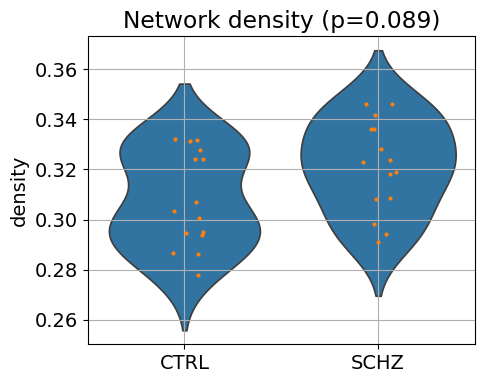

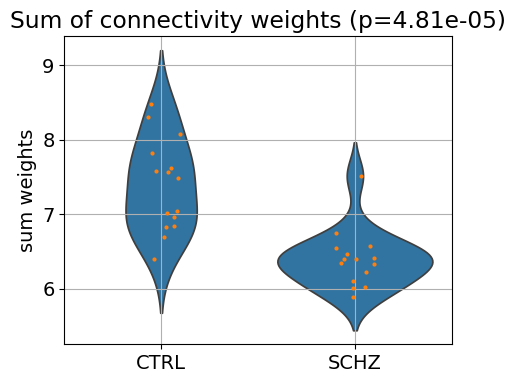

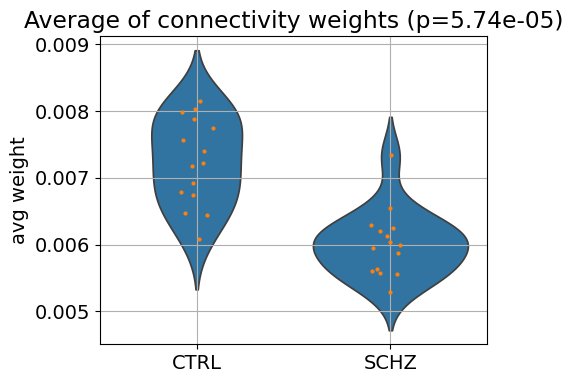

In [38]:
# Density
d_ctrl = np.sum(np.sum(SC_ctrl > 0, axis=0), axis=0) / (nn * (nn - 1))
d_schz = np.sum(np.sum(SC_schz > 0, axis=0), axis=0) / (nn * (nn - 1))

# Sum of weights (divide by 2 for undirected double counting)
wsum_ctrl = np.sum(np.sum(SC_ctrl, axis=0), axis=0) / 2.0
wsum_schz = np.sum(np.sum(SC_schz, axis=0), axis=0) / 2.0

# Average weight among existing edges
num_ctrl = np.sum(np.sum(SC_ctrl > 0, axis=0), axis=0)
num_schz = np.sum(np.sum(SC_schz > 0, axis=0), axis=0)
wavg_ctrl = (2.0 * wsum_ctrl) / num_ctrl
wavg_schz = (2.0 * wsum_schz) / num_schz

def ranksum_p(x, y):
    return mannwhitneyu(x, y, alternative="two-sided").pvalue

def violin_two_groups(x1, x2, title, ylab):
    df = {
        "value": np.concatenate([x1, x2]),
        "group": ["CTRL"] * len(x1) + ["SCHZ"] * len(x2),
    }
    plt.figure(figsize=(5,4))
    sns.violinplot(x=df["group"], y=df["value"], inner=None)
    sns.stripplot(x=df["group"], y=df["value"], size=3)
    plt.grid(True)
    plt.title(title)
    plt.ylabel(ylab)
    plt.show()

p = ranksum_p(d_ctrl, d_schz)
violin_two_groups(d_ctrl, d_schz, f"Network density (p={p:.3g})", "density")

p = ranksum_p(wsum_ctrl, wsum_schz)
violin_two_groups(wsum_ctrl, wsum_schz, f"Sum of connectivity weights (p={p:.3g})", "sum weights")

p = ranksum_p(wavg_ctrl, wavg_schz)
violin_two_groups(wavg_ctrl, wavg_schz, f"Average of connectivity weights (p={p:.3g})", "avg weight")

<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    Do healthy subjects and schizophrenia patients significantly differ in terms of network density or connectivity-weight sum?<br>
    Can these differences influence network measures such as the weighted and the binary network efficiency? How? <br><br>
    Which approached could you think off to correct for average or sum connectivit-weight group effect?<br>
<br>
</div>

## 3.2 Altered network integration in schiziphrnia patients

Compute the **weighted global efficiency** for all healthy controls and patients with schizophrenia. To account for between-group differences in *overall connectivity weights*, one possible strategy is to normalize individual connectivity matrices by their connectivity-weight sum before assessing the topological organization of the connectome.<br> 
After having normalized the weights of the individual brain networks and computed their weighted global efficiency, compare both groups with a non-parametric statistical test.

In [39]:
print(wsum_ctrl)

[6.69298136 8.30762984 6.83710923 6.82690417 7.04295255 7.01683267
 7.56215093 6.39852055 8.0798877  6.96695158 7.82499127 8.48307941
 7.6284898  7.48697861 7.57991797]


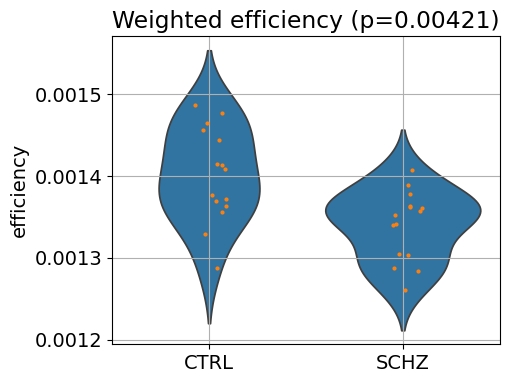

In [44]:
# numpy array initialization
SC_ctrl_norm = np.zeros((nn,nn,ns), dtype=float)
SC_schz_norm = np.zeros((nn,nn,ns), dtype=float)
Eff_ctrl = np.zeros((ns,), dtype=float)
Eff_schz = np.zeros((ns,), dtype=float)

# --- normalize network weights and compute weighted efficiency ---
for i in range(ns):
    SC_ctrl_norm[:,:,i] = SC_ctrl[:,:,i] / wsum_ctrl[i];
    Eff_ctrl[i] = bct.efficiency_wei(SC_ctrl_norm[:,:,i], local=False)
    SC_schz_norm[:,:,i] = SC_schz[:,:,i] / wsum_schz[i];
    Eff_schz[i] = bct.efficiency_wei(SC_schz_norm[:,:,i], local=False)

# --- compare network efficiency between groups (non parametric test) ---
p = ranksum_p(Eff_ctrl, Eff_schz)

violin_two_groups(Eff_ctrl, Eff_schz, f"Weighted efficiency (p={p:.3g})", "efficiency")

Visualize the *bct.efficiency_wei* help.<br>
Beware that this function computes the network efficiency using an **auxiliary connection-length matrix** *L*,defined *as L_ij = 1/W_ij* for all nonzero *L_ij*. This has an intuitive interpretation, as higher connection weights intuitively
correspond to shorter lengths. However, other **connectivity strength-to-length mappings** could have been used.

In [47]:
help(bct.efficiency_wei)

Help on function efficiency_wei in module bct.algorithms.efficiency:

efficiency_wei(Gw, local=False)
    The global efficiency is the average of inverse shortest path length,
    and is inversely related to the characteristic path length.
    
    The local efficiency is the global efficiency computed on the
    neighborhood of the node, and is related to the clustering coefficient.
    
    Parameters
    ----------
    W : NxN np.ndarray
        undirected weighted connection matrix
        (all weights in W must be between 0 and 1)
    local = bool or enum
        If True or 'local', computes local efficiency instead of global efficiency.
        If False or 'global', uses the global efficiency
        If 'original', will use the original algorithm provided by (Rubinov
        & Sporns 2010). This version is not recommended. The local efficiency
        calculation was improved in (Wang et al. 2016) as a true generalization
        of the binary variant.
        
    Returns
    --

<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    Is the efficiency of the brain networks in schizophrenia increased, decreased or unchanged with respect to the control group?<br>
    How would you interpret these findings?<br><br>
    What is the impact of the choice of connectivity strength-to-length mapping on results?<br>
<br>
</div>

We now wish to identify which brain regions show the largest alterations and contribute the most to the overall network efficiency impairment seen in schizophrenia. To do so, compute the nodal closeness centralities for both the healthy controls and schizophrenia patients’ networks, applying the same normalization strategy as above and using the *distance_wei bctpy* function.<br>
Beware that a **connection-length matrix** should be used instead of a **connection-strength matrix** when summoning this function. For simplicity, you can here convert a connectivity strength weight into a length by taking its inverse.

In [52]:
def weight_to_length(W):
    # --- convert weights to lengths for distance_wei: L = 1/W for W>0 ---
    # create a new array with the same shape as W
    L = np.full_like(W, np.inf, dtype=float)
    m = W > 0
    L[m] = 1.0 / W[m]
    np.fill_diagonal(L, 0.0)
    return L

# --- compute nodal closeness centrality per subject ---
Cent_ctrl = np.zeros((ns, nn), dtype=float)
Cent_schz = np.zeros((ns, nn), dtype=float)

for i in range(ns):
    L = weight_to_length(SC_ctrl_norm[:, :, i])
    D = bct.distance_wei(L)
    D = D[0]
    Cent_ctrl[i, :] = (nn - 1) / np.sum(D, axis=0)

    L = weight_to_length(SC_schz_norm[:, :, i])
    D = bct.distance_wei(L)
    D = D[0]
    Cent_schz[i, :] = (nn - 1) / np.sum(D, axis=0)

# --- compare CTRL vs SCHZ node-by-node (Mann–Whitney / ranksum) ---
pvals = np.array([
    mannwhitneyu(Cent_ctrl[:, j], Cent_schz[:, j], alternative="two-sided").pvalue
    for j in range(nn)
])

<div style="background-color:#e8f0fe; padding:10px; border-radius:8px">
<b>Questions:</b> <br><br>
    How would you identify which brain regions have impaired network centrality in patients compared to control subjects?<br>
    Is a multiple comparison correction needed in this case?<br>
<br>
</div>

As a final step, let's apply a **multiple comparison correction** to control the **False Discovery Rate (FDR)**, i.e., the expected proportion of incorrectly rejected null hypotheses, in the nodal centrality group-comparisons.

In [56]:
# BH-FDR correction 
rej, fdr_pvals, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
sig_idx = np.where(rej)[0]

print("Nodes with uncorrected p<0.05:", int(np.sum(pvals < 0.05)))
print("Nodes surviving BH-FDR (q<0.05):", len(sig_idx))

# Show significant nodes sorted by FDR p-value
if len(sig_idx) > 0:
    order = sig_idx[np.argsort(fdr_pvals[sig_idx])]
    print("\nTop FDR-significant nodes:")
    for j in order[:20]:
        name = labels[j] if "labels" in globals() else str(j)
        print(f"{j:3d}  {name:>25s}  FDR p={fdr_pvals[j]:.3g}  raw p={pvals[j]:.3g}")
else:
    print("No nodes survive BH-FDR at q<0.05.")

Nodes with uncorrected p<0.05: 36
Nodes surviving BH-FDR (q<0.05): 18

Top FDR-significant nodes:
  8     rh_caudalmiddlefrontal  FDR p=0.0173  raw p=0.000422
 37                rh_pallidum  FDR p=0.0173  raw p=0.000361
 44     lh_medialorbitofrontal  FDR p=0.0183  raw p=0.000671
 76                 lh_caudate  FDR p=0.0331  raw p=0.00246
 36                 rh_putamen  FDR p=0.0331  raw p=0.00162
 69        lh_inferiortemporal  FDR p=0.0331  raw p=0.00246
 63        lh_lateraloccipital  FDR p=0.0331  raw p=0.00282
 75          lh_thalamusproper  FDR p=0.0338  raw p=0.00421
 70          lh_middletemporal  FDR p=0.0338  raw p=0.00702
 58        lh_superiorparietal  FDR p=0.0338  raw p=0.00702
  3     rh_medialorbitofrontal  FDR p=0.0338  raw p=0.00421
 78                lh_pallidum  FDR p=0.0338  raw p=0.00545
 42           lh_parsorbitalis  FDR p=0.0338  raw p=0.00545
 35                 rh_caudate  FDR p=0.0338  raw p=0.00479
 15             rh_postcentral  FDR p=0.0338  raw p=0.00619